# Preparing the Data

In [1]:
# Before getting to our neural network, we first need to prepare our data.
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose)
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

## Making a TensorFlow Dataset

In [2]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('data/val_images.tfrecords')

In [3]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [4]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [5]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


In [6]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [7]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [8]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [9]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

In [10]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

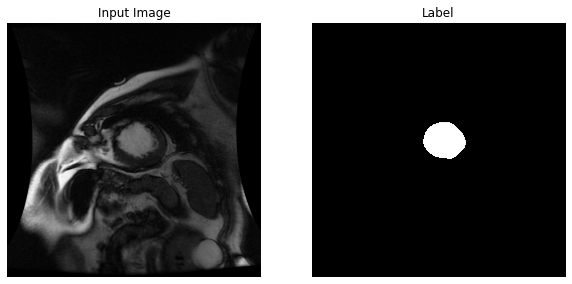

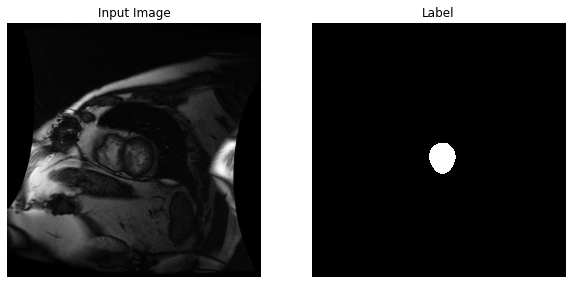

In [11]:
# display an image and label from the training set
for image, label in train.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

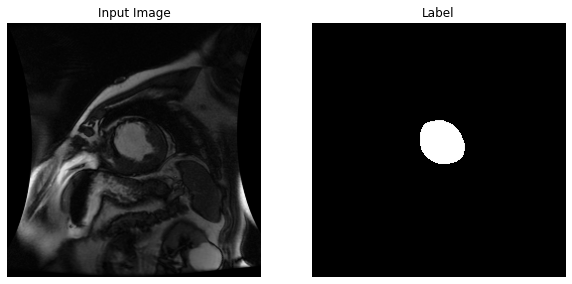

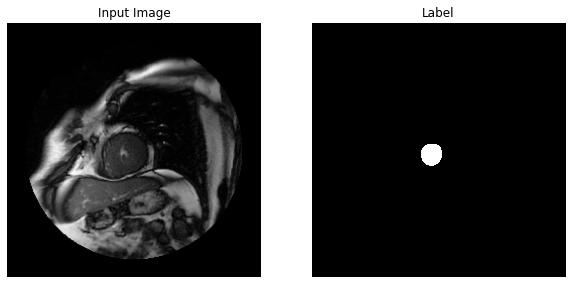

In [12]:
# display an image and label from the test set
for image, label in val.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

In [13]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [14]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

In [17]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [19]:
# print out the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 128, 128, 100)     2600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 200)       500200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 300)       810300    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 2)         6

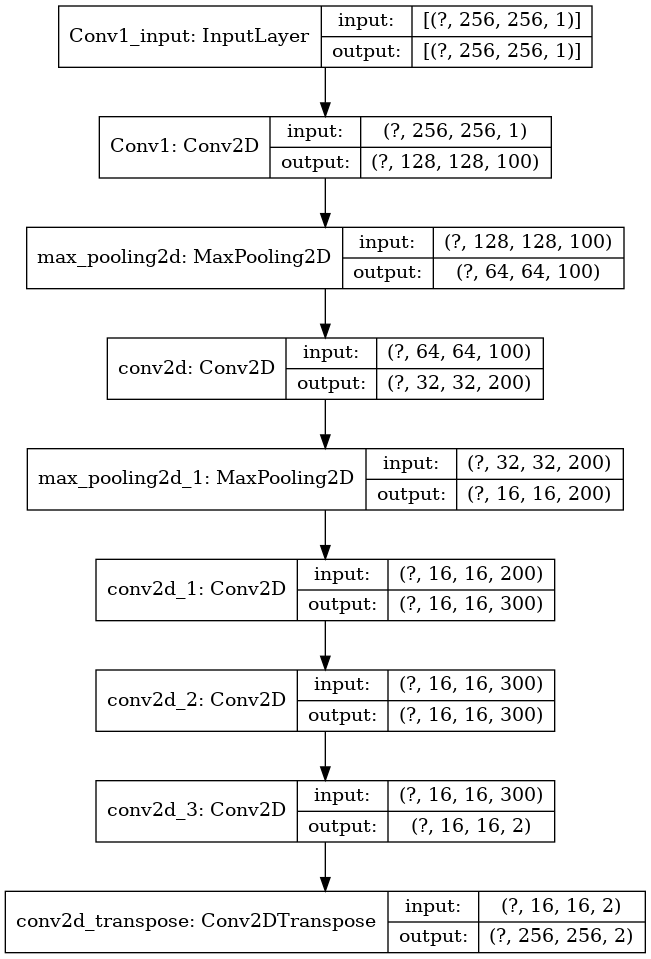

In [20]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

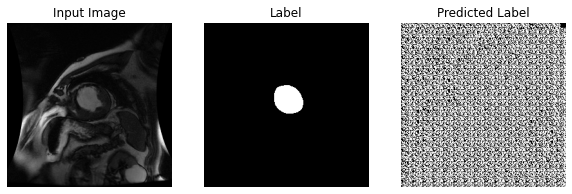

In [21]:
# show a predection, as an example
show_predictions(test_dataset)

In [22]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [24]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Train for 234 steps, validate for 26 steps
Epoch 1/20
229/234 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9984

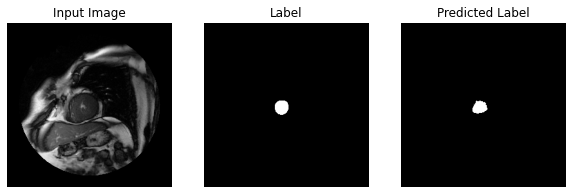


Sample Prediction after epoch 1

234/234 [==============================] - 2s 7ms/step - loss: 0.0037 - accuracy: 0.9984 - val_loss: 0.0087 - val_accuracy: 0.9972
Epoch 2/20
231/234 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9984

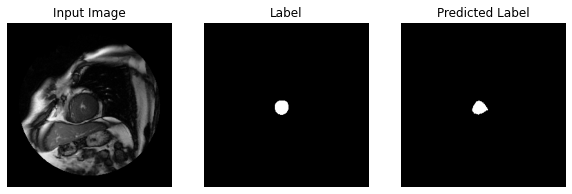


Sample Prediction after epoch 2

234/234 [==============================] - 2s 7ms/step - loss: 0.0037 - accuracy: 0.9984 - val_loss: 0.0074 - val_accuracy: 0.9974
Epoch 3/20
231/234 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9985

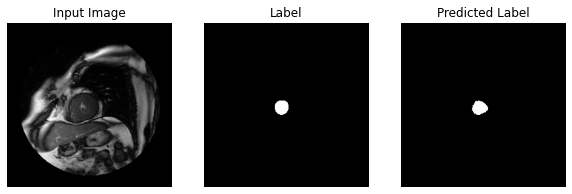


Sample Prediction after epoch 3

234/234 [==============================] - 2s 7ms/step - loss: 0.0034 - accuracy: 0.9985 - val_loss: 0.0075 - val_accuracy: 0.9974
Epoch 4/20
231/234 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9986

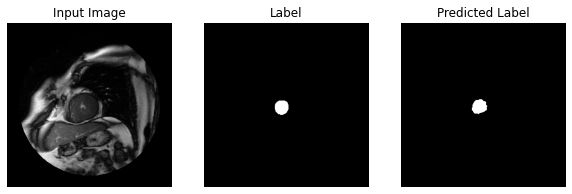


Sample Prediction after epoch 4

234/234 [==============================] - 2s 7ms/step - loss: 0.0033 - accuracy: 0.9986 - val_loss: 0.0085 - val_accuracy: 0.9972
Epoch 5/20
231/234 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9983

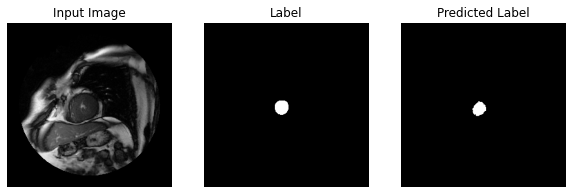


Sample Prediction after epoch 5

234/234 [==============================] - 2s 7ms/step - loss: 0.0045 - accuracy: 0.9982 - val_loss: 0.0110 - val_accuracy: 0.9960
Epoch 6/20
231/234 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9979

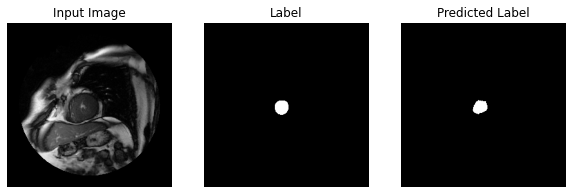


Sample Prediction after epoch 6

234/234 [==============================] - 2s 7ms/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.0084 - val_accuracy: 0.9972
Epoch 7/20
228/234 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9986

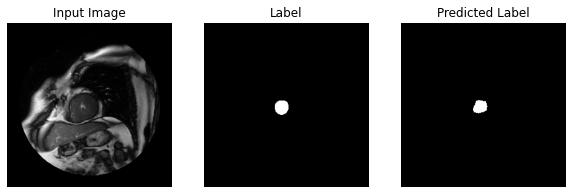


Sample Prediction after epoch 7

234/234 [==============================] - 2s 7ms/step - loss: 0.0034 - accuracy: 0.9986 - val_loss: 0.0087 - val_accuracy: 0.9971
Epoch 8/20
231/234 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9988

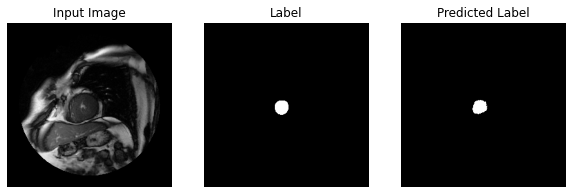


Sample Prediction after epoch 8

234/234 [==============================] - 2s 7ms/step - loss: 0.0028 - accuracy: 0.9988 - val_loss: 0.0087 - val_accuracy: 0.9973
Epoch 9/20
230/234 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9988

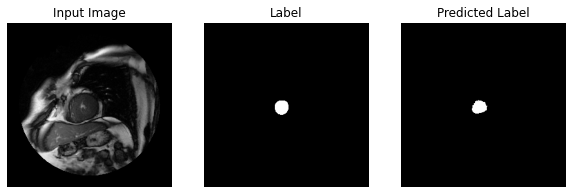


Sample Prediction after epoch 9

234/234 [==============================] - 2s 7ms/step - loss: 0.0029 - accuracy: 0.9988 - val_loss: 0.0079 - val_accuracy: 0.9975
Epoch 10/20
231/234 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9989

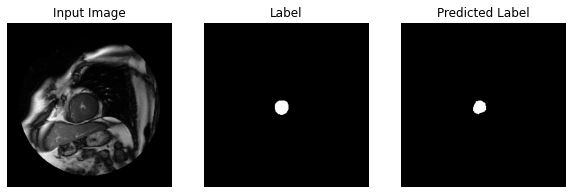


Sample Prediction after epoch 10

234/234 [==============================] - 2s 7ms/step - loss: 0.0026 - accuracy: 0.9989 - val_loss: 0.0086 - val_accuracy: 0.9976
Epoch 11/20
231/234 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9989

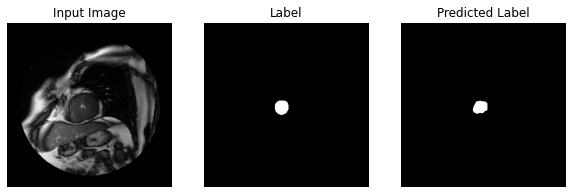


Sample Prediction after epoch 11

234/234 [==============================] - 2s 7ms/step - loss: 0.0026 - accuracy: 0.9989 - val_loss: 0.0089 - val_accuracy: 0.9974
Epoch 12/20
231/234 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9987

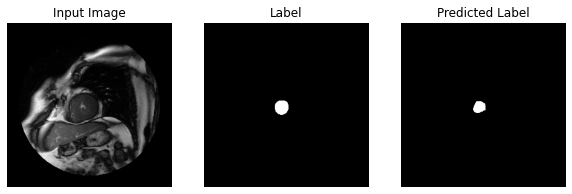


Sample Prediction after epoch 12

234/234 [==============================] - 2s 7ms/step - loss: 0.0031 - accuracy: 0.9987 - val_loss: 0.0086 - val_accuracy: 0.9975
Epoch 13/20
231/234 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9988

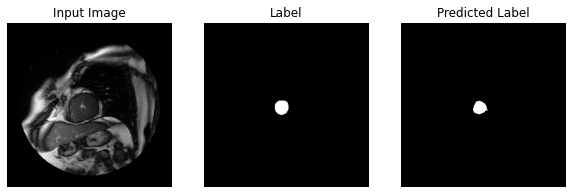


Sample Prediction after epoch 13

234/234 [==============================] - 2s 7ms/step - loss: 0.0027 - accuracy: 0.9988 - val_loss: 0.0090 - val_accuracy: 0.9976
Epoch 14/20
230/234 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9988

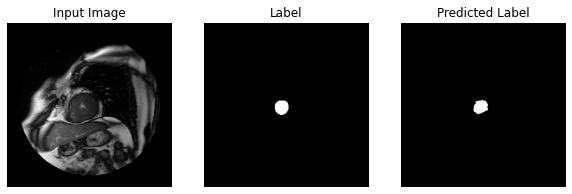


Sample Prediction after epoch 14

234/234 [==============================] - 2s 7ms/step - loss: 0.0027 - accuracy: 0.9988 - val_loss: 0.0089 - val_accuracy: 0.9974
Epoch 15/20
231/234 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9987

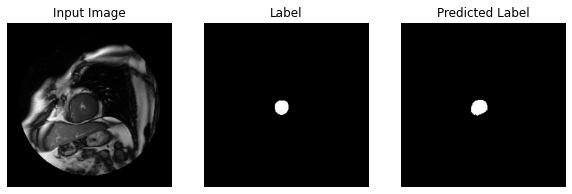


Sample Prediction after epoch 15

234/234 [==============================] - 2s 7ms/step - loss: 0.0029 - accuracy: 0.9987 - val_loss: 0.0108 - val_accuracy: 0.9969
Epoch 16/20
230/234 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9988

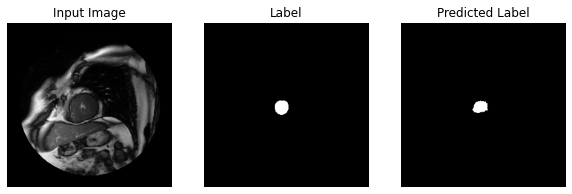


Sample Prediction after epoch 16

234/234 [==============================] - 2s 7ms/step - loss: 0.0028 - accuracy: 0.9988 - val_loss: 0.0088 - val_accuracy: 0.9975
Epoch 17/20
231/234 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9989

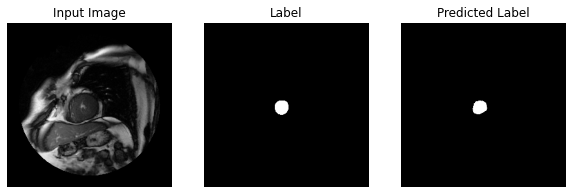


Sample Prediction after epoch 17

234/234 [==============================] - 2s 7ms/step - loss: 0.0026 - accuracy: 0.9989 - val_loss: 0.0087 - val_accuracy: 0.9976
Epoch 18/20
231/234 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9989

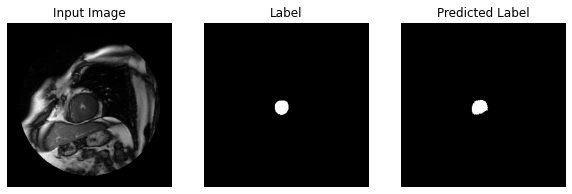


Sample Prediction after epoch 18

234/234 [==============================] - 2s 7ms/step - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0088 - val_accuracy: 0.9975
Epoch 19/20
231/234 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9989

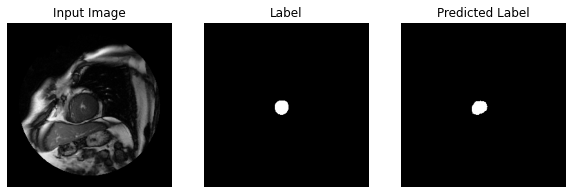


Sample Prediction after epoch 19

234/234 [==============================] - 2s 7ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.0103 - val_accuracy: 0.9973
Epoch 20/20
231/234 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9989

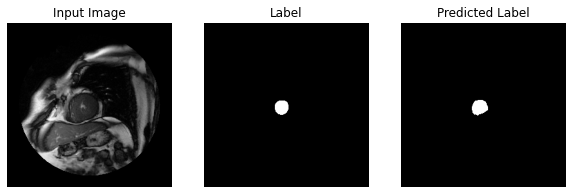


Sample Prediction after epoch 20

234/234 [==============================] - 2s 7ms/step - loss: 0.0026 - accuracy: 0.9989 - val_loss: 0.0094 - val_accuracy: 0.9974


In [26]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

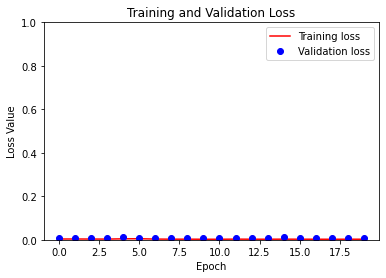

In [27]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [28]:
model.evaluate(test_dataset)

     26/Unknown - 0s 4ms/step - loss: 0.0094 - accuracy: 0.9974

[0.009379303790270709, 0.99741894]

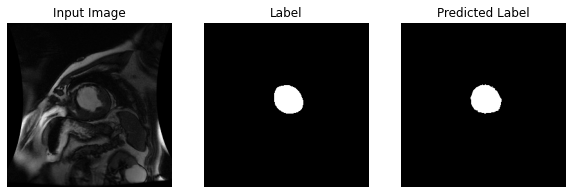

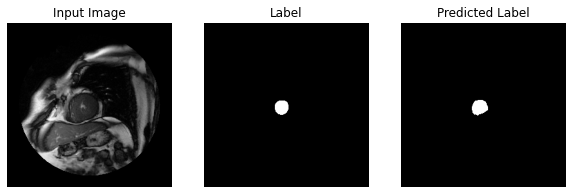

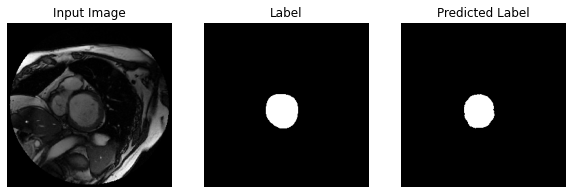

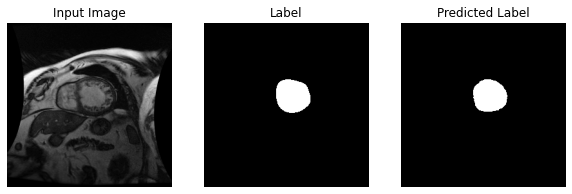

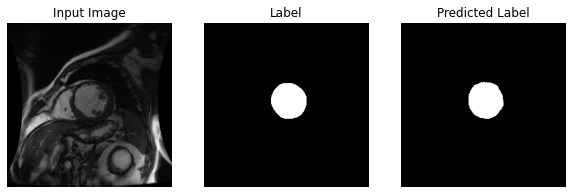

In [29]:
# show predictions from the test data set that has NOT been used for training.
show_predictions(test_dataset, 5)

In [30]:
model.save("cardio.h5")